In [1]:
#import necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import cv2 as cv
import albumentations as alb
import imgaug as aug
import imgaug.augmenters as iaa
import tensorflow as tf
from keras.utils import to_categorical

Using TensorFlow backend.


## Preprocessing Data

In [2]:
#Set path for dataset
PATH_DATA = r"C:/Users/Kristen/Documents/Kristen/CS 539/ProjectData"
#Set training dataset paths
PATH_TRAIN_DAY = r"C:/Users/Kristen/Documents/Kristen/CS 539/ProjectData/Annotations/Annotations/dayTrain"
PATH_TRAIN_NIGHT = r"C:/Users/Kristen/Documents/Kristen/CS 539/ProjectData/Annotations/Annotations/nightTrain"
os.listdir(PATH_DATA)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [3]:
#Create labeled csv dataset for daytime training
train_day = []
for im in tqdm(sorted(os.listdir(PATH_TRAIN_DAY))):
    df = pd.read_csv(os.path.join(PATH_TRAIN_DAY,im,r"frameAnnotationsBOX.csv"),sep=";")
    train_day.append(df)
df = pd.concat(train_day, axis=0)
#get rid of unecessary data cols
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

100%|██████████| 13/13 [00:00<00:00, 96.65it/s] 


#### This is commented out (and the other night training dataset), because it is messing with the renaming the file names. To set up night dataset, do all of daytime proprocessing first, then all of nightitme. ORR: combind dataset somehow

In [4]:
# #Create labeled csv dataset for nighttime training
# train_night = []
# for im in tqdm(sorted(os.listdir(PATH_TRAIN_NIGHT))):
#     df = pd.read_csv(os.path.join(PATH_TRAIN_NIGHT,im,r"frameAnnotationsBOX.csv"),sep=";")
#     train_night.append(df)
# df_train_night = pd.concat(train_night, axis=0)
# #get rid of unecessary data cols
# df_train_night = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)
# print(df_train_night)

In [5]:
#Change file name to specific image number
def changeFile(file):
    fl = file.Filename
    split = fl.split('/')
    clipNum = split[-1].split('--')[0]
    return os.path.join(PATH_DATA, f"dayTrain/dayTrain/{clipNum}/frames/{split[-1]}").replace("\\","/")
#print(PATH_DATA)
df['Filename'] = df.apply(changeFile, axis=1)
df['Filename'][0]
#df_train_night['Filename'] = df.apply(changeFile, axis=1)
#print(df['Filename'][1939])

#df['Annotation tag'].unique()
#df['Annotation tag'][13]
# df_train_night['Annotation tag'].unique()

0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
Name: Filename, dtype: object

In [6]:
#create dictionary of labels
label_dict = {'go':1, 'warning':2, 'stop':3}

def changeAnnotation(tag):
    if 'go' in tag['Annotation tag']:
        return label_dict['go']
    elif 'warning' in tag['Annotation tag']:
        return label_dict['warning']
    elif 'stop' in tag['Annotation tag']:
        return label_dict['stop']

df['Annotation tag'] = df.apply(changeAnnotation, axis=1)
#df_train_night['Annotation tag'] = df.apply(changeAnnotation, axis=1)


tags_day = df['Annotation tag'].unique()
print(tags_day)
# df['Annotation tag'][13]

[1 3 2]


In [7]:
#rename column headers
df.columns = ['id','label','xmin','ymin','xmax','ymax','frame_num']
print(df['id'][0])
#df_train_night.columns = ['id','label','xmin','ymin','xmax','ymax','frame_num']

0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
0    C:/Users/Kristen/Documents/Kristen/CS 539/Proj...
Name: id, dtype: object


960
1280
3
960
1280
3
960
1280
3


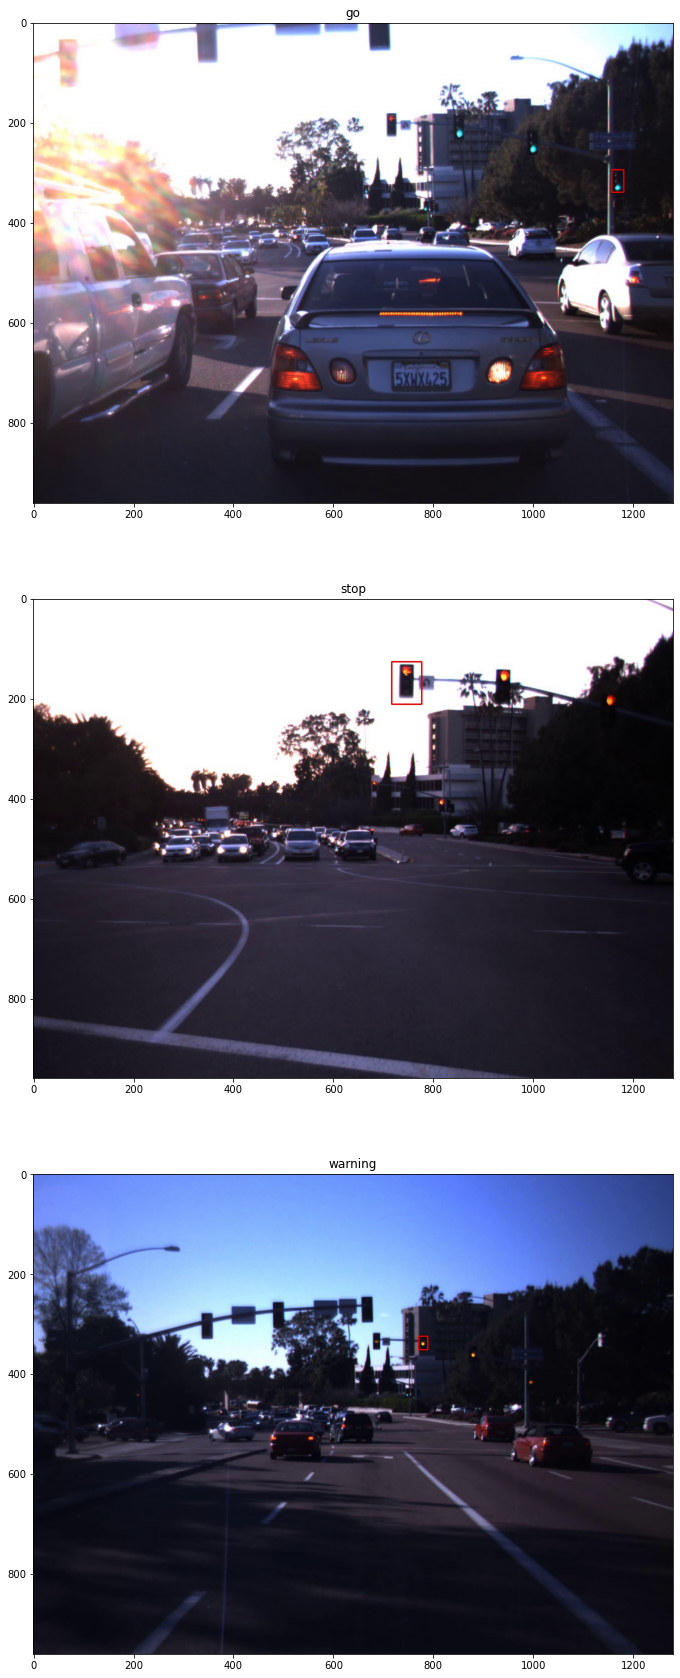

In [8]:
fig, ax = plt.subplots(len(tags_day),1, figsize=(15,10*len(tags_day)))
# sample = df['id'][0]
# box = [df['xmin'][0],df['ymin'][0],df['xmax'][0],df['ymax'][0]]
# print(sample)
# print(box)
# im = cv.imread(sample)
# im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
# cv.imshow('test',im)


for i,tag in enumerate(tags_day):
    sample = df[df['label']==tag].sample(1)
    box = sample[['xmin','ymin','xmax','ymax']].values[0]
    im = cv.imread(sample.id.values[0])
    #cv.imshow('',im)
    im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
    
    cv.rectangle(im,(box[0],box[1]),(box[2],box[3]),(220,0,0),2)
    pos = list(label_dict.values()).index(tag)
    ax[i].set_title(list(label_dict.keys())[pos])
    ax[i].imshow(im)
    print(np.size(im,0))
    print(np.size(im,1))
    print(np.size(im,2))
    
# sample1 = df[df['label']==1].sample(1)
# box1 = sample1[['xmin','ymin','xmax','ymax']].values[0]
# im1 = cv.imread(sample1.id.values[0])
# cv.imshow('test',im1)
# im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY)

# sample2 = df[df['label']==2].sample(1)
# box2 = sample2[['xmin','ymin','xmax','ymax']].values[0]
# im2 = cv.imread(sample1.id.values[0])
# #im2 = cv.cvtColor(im2,cv.COLOR_BGR2RGB)

# sample3 = df[df['label']==3].sample(1)
# box3 = sample3[['xmin','ymin','xmax','ymax']].values[0]
# im3 = cv.imread(sample1.id.values[0])
# #im3 = cv.cvtColor(im3,cv.COLOR_BGR2RGB)

# cv.rectangle(im1,(box1[0],box1[1]),(box1[2],box1[3]))
# cv.rectangle(im2,(box2[0],box2[1]),(box2[2],box2[3]))
# cv.rectangle(im3,(box3[0],box3[1]),(box3[2],box3[3]))

# imshow(im1)
# imshow(im2)
# imshow(im3)

In [9]:
# print(df['id'][0])
df['clipNames'] = df[['id']].applymap(lambda x: x.split('/')[9])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

In [10]:
#slipt dataset to training and testing, with validation sets
def trainAndTestSet(df,p=.25):
#     dayClips = []
    clipNames = sorted(df['clipNames'].unique())
#     for clip in clipNames:
#         if 'day' in clip:
#             dayClips.append(clip)
    dayClips = [clip for clip in clipNames if 'day' in clip]
    
    print(len(dayClips))
    print(int(len(dayClips)*p))
    testDayClips = list(np.random.choice(dayClips, int(len(dayClips)*p)))
    testClips = testDayClips
    
    #print()
    trainDayClips = list(set(dayClips) - set(testClips))
    trainClips = trainDayClips
    
    train = df[df.clipNames.isin(trainClips)]
    test = df[df.clipNames.isin(testClips)]
    
    return train, test

train, test = trainAndTestSet(df)
train, val = trainAndTestSet(train)
train.id.values[0]

13
3
10
2


'C:/Users/Kristen/Documents/Kristen/CS 539/ProjectData/dayTrain/dayTrain/dayClip10/frames/dayClip10--00000.jpg'

### At this point I changed df_train_day to df, and it fixed problems... idk why

In [11]:
cases_count = train['label'].value_counts()
print(cases_count)
cases_count = list(cases_count) #in order of 3,1,2. Stop, go, warning

3    12050
1     6887
2      554
Name: label, dtype: int64


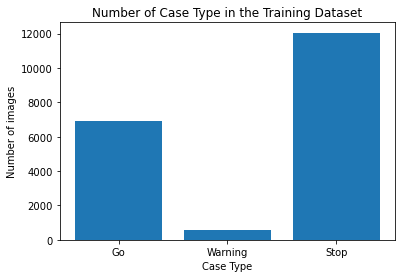

In [12]:
plt.figure()
x = ['Go','Warning','Stop']
height=[cases_count[1],cases_count[2],cases_count[0]]
plt.bar(x,height)
plt.title("Number of Case Type in the Training Dataset")
plt.ylabel("Number of images")
plt.xlabel("Case Type")
plt.show()

3    9400
1    6539
2     345
Name: label, dtype: int64


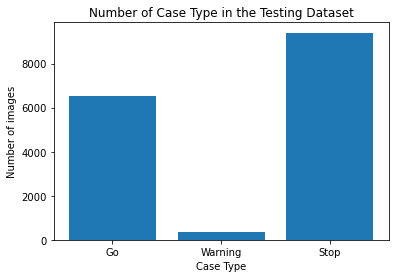

In [13]:
cases_count = test['label'].value_counts()
print(cases_count)
cases_count = list(cases_count) #in order of 3,1. Stop, go
plt.figure()
x = ['Go','Warning','Stop']
height=[cases_count[1],cases_count[2],cases_count[0]]
plt.bar(x,height)
plt.title("Number of Case Type in the Testing Dataset")
plt.ylabel("Number of images")
plt.xlabel("Case Type")
plt.show()

1    1255
3     634
2     146
Name: label, dtype: int64


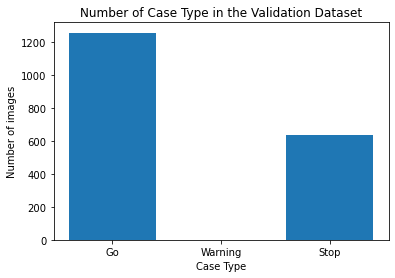

In [14]:
cases_count = val['label'].value_counts()
print(cases_count)
cases_count = list(cases_count) #in order of 3,1,2. Stop, go, warning

plt.figure()
x = ['Go','Warning','Stop']
height=[cases_count[0],0,cases_count[1]]
plt.bar(x,height)
plt.title("Number of Case Type in the Validation Dataset")
plt.ylabel("Number of images")
plt.xlabel("Case Type")
plt.show()

#### As you can see from the training, testing, and the validation sets, the data is highly imbalanced. There is significantly more stop and go cases than waring (yellow light) cases. This is typical in traffic light data, as there is much more time that the light is on go or stop. In this case, there is more stop cases than even go cases, which is also common in traffic data.

## Create Dataloader (generator?)

In [15]:
# class TrafficLight:
#     def __init__(self,df,transforms=None):
#         super().__init__()
        
#         self.image_ids = df.id.unique()
#         self.df = df
#         self.transforms = transforms
    
#     def __getitem__(self,index:int):
#         img_id = self.image_ids[index]
#         records = self.df[self.df.id == img_id]
        
#         img = cv.imread(img_id)
#         img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)
#         img /= 255
        
#         box = records[['xmin','ymin','xmax','ymax']]
#         box = tf.convert_to_tensor(box, dtype=tf.float32)
        
#         area = (box[:,3]-box[:,1])*(box[:,2]-box[:,0])
#         area = tf.convert_to_tensor(area, dtype=tf.float32)
        
#         labels = tf.convert_to_tensor(records.label.values, dtype=tf.int64)
#         iscrowd = tf.zeros_like(labels, dtype=tf.int64)
        
#         target = {}
#         target['box'] = box
#         target['labels'] = labels
#         target['id'] = tf.Tensor([index])
#         target['area'] = area
#         target['iscrowd'] = iscrowd
        
#         if self.trasforms:
#             sample= {
#                 'image' : image,
#                 'box' : target['box'],
#                 'labels' : labels}
#             sample = self.transofrms(**sample)
#             image = sample['image']
#             target['box'] = tf.convert_to_tensor(sample['box'],dtype=tf.float32)
#             target['labels'] = tf.convert_to_tensor(sample['labels'])
           
        
#         return img, target, img_id

In [16]:
# class LossAverager:
#     #Reset instance
#     def __init__(self):
#         self.reset()
    
#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0
    
#     def update(self,val, n=1):
#         slef.val = val
#         self.sum += val*n
#         self.count += n
#         self.avg = self.sum/self.count
    

#### What is collate_fcn???

In [17]:
# def collate_fcn(batch):
#     return tuple(zip(*batch))

In [18]:
# def getTransform(img_id):
#     img_raw = tf.io.read_file(path)
#     img = tf.io.decode_image(img_raw)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     img = tf.image.resize(img,[256,256])
#     img = tf.image.random_flip_up_down(img)
#     box_params = {'format':'pascal_voc', 'label_fields':['labels']}
#     return img, box_params

## Define Hyperparameters

In [19]:
BATCH_SIZE = 2
EPOCHS = 1

## Retry at Generator

In [20]:
aug_seq = iaa.OneOf([iaa.Fliplr(),iaa.Affine(rotate=20),iaa.Multiply((1.2,1.5))])

In [21]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size
#     print("in fcn")
    batch_data = np.zeros((batch_size, 256,256,3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,4), dtype=np.float32)
    
    indicies = np.arange(n)
    
    i=0
    more_data = True 
    while more_data:
        np.random.shuffle(indicies)
        count=0
        next_batch = indicies[(i*batch_size):(i+1)*batch_size]
        
        for j, index in enumerate(next_batch):
            img_name = data.iloc[index]['id']
            label = data.iloc[index]['label']
#             print('label:')
#             print(label)
            encoded_label = to_categorical(label) #, num_classes=3
            
            img = cv.imread(str(img_name))
            img = cv.resize(img, (256,256))
            
            orig_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255
            
#             print('encoded_label:')
#             print(encoded_label)
#             print('batch_labels:')
#             print(batch_labels)
#             print(f'batch_labels[{count}]:')
#             print(batch_labels[count])
            batch_data[count] = orig_img
            
            batch_labels[count][len(encoded_label)-1] = encoded_label[-1]
#             print('New batch_labels:')
#             print(batch_labels)
            
            aug_img = aug_seq.augment_image(img)
            aug_img = cv.cvtColor(aug_img, cv.COLOR_BGR2RGB)
#             print("aug_img type:")
#             print(type(aug_img))
            aug_img = aug_img.astype(np.float32)
#             print("batch_data size:")
#             print(batch_data.shape)
#             print("aug_img size:")
#             print(aug_img.shape)

            if count < batch_size - 1:
#                 aug_img_reshape = aug_img.reshape(1,aug_img.shape[0],aug_img.shape[1],aug_img.shape[2])
#             print(aug_img_reshape.shape)
#                 batch_data = np.concatenate((batch_data,aug_img_reshape), axis=0)
    #             print("batch_data size:")
    #             print(batch_data.shape)
                batch_data[count+1] = aug_img
#                 print('encoded_label:')
#                 print(encoded_label)
#                 print('batch_labels:')
#                 print(batch_labels)
                batch_labels[count+1][len(encoded_label)-1] = encoded_label[-1]
#                 print('New 2 batch_labels:')
#                 print(batch_labels)
                count += 1
#             print("here")
            count+=1
            if count >= batch_size-1:
                #print("here")
                more_data = False
                break
        i += 1
        yield batch_data, batch_labels
        
        if i>=steps:
            i=0

In [22]:
#Test Generator
train_data_gen = {"Data":None, "Label":None}
i=0
for val in tqdm(data_gen(train,len(train))):
    train_data_gen["Data"] = val[0]
    train_data_gen["Label"] = val[1]
    if i == 0:
        print(np.shape(val[0]))
        print(val[1])
    if i==1:
        print(np.shape(val[0]))
        print(val[1])
    print(i)
    i +=1
# train_data_gen = data_gen(train,BATCH_SIZE)[0]
# print(train_data_gen)

1it [03:10, 190.31s/it]

(19491, 256, 256, 3)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]
0


#### Create Base Model

In [23]:
print(len(train_data_gen["Label"]))
print(np.shape(train_data_gen["Data"]))

19491
(19491, 256, 256, 3)


In [24]:
IMG_SHAPE = np.shape(train_data_gen["Data"])[1:4]

base_model = tf.keras.applications.InceptionResNetV2(
            include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

In [25]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 14, 14, 192)  208896      block17_9_ac[0][0]               
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 14, 14, 192)  215040      activation_114[0][0]             
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 14, 14, 192)  576         conv2d_112[0][0]                 
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 14, 14, 192)  576         conv2d_115[0][0]                 
__________________________________________________________________________________________________
activation_112 (Activation)     (None, 14, 14, 192)  0           batch_normalization_112[0][0]    
__________

In [26]:
max_pool_layer = tf.keras.layers.GlobalMaxPool2D()
# d = np.shape(max_pool_layer)[0]*np.shape(max_pool_layer)[1]
# dense_layer = tf.keras.layers.Dense(d)


In [27]:
#build model

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = max_pool_layer(x)
x = tf.keras.layers.Dropout(.2)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs,output)

In [28]:
lr = .0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [30]:
len(model.trainable_variables)

490

In [ ]:
# type(train_data_gen["Data"])
# type(train_data_gen["Label"])

trained_model = model.fit(train_data_gen["Data"],train_data_gen["Label"],
            epochs=EPOCHS, 
             batch_size= BATCH_SIZE)

Train on 19491 samples
 4254/19491 [=====>........................] - ETA: 3:42:52 - loss: 1.3970 - accuracy: 0.6321